In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from PIL import Image

In [2]:
def load_image(file):
    if '.png' in file:
        image = plt.imread(file)
    if '.jpg' in file:
        image = plt.imread(file)/255
    return image

"""
X: dataset, reshaped image 
K: reduced number of colors (number of centroids) 
centroids: matrix, i-th row corresponds to the i-th centroid 
idx: list of indexes ranging from 0 to K - 1: idx[127] = 4 means that the register 127 was associated to the centroid 4
"""

#Function that returns K random registers of the dataset X   
def kmeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0]) 
    return X[randidx[:K]]  

#Function that, given the dataset X and centroids, returns the index of the closest centroid to each register of X 
def closest_centroid(X, centroids): 
    idx = np.zeros(X.shape[0], dtype = int) 
    for i in range(X.shape[0]):
        distances_i = [] 
        for j in range(centroids.shape[0]): 
            d_ij = distance.euclidean(X[i,:], centroids[j, :])
            distances_i.append(d_ij)
        idx[i] = np.argmin(distances_i) 
    return idx

#Function that returns the actualized centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1])) 
    for i in range(K): 
        X_i = []  
        for j in range(X.shape[0]):
            if idx[j] == i:
                X_i.append(X[j,:]) 
        centroids[i] = np.sum(X_i, axis = 0)/len(X_i)
    return centroids

#K-means algorithm
def run_kmeans(X, centroids_init, iterations = 10):
    centroids = centroids_init
    K = centroids_init.shape[0]
    for i in range(iterations):
        #print("K-Means iteration %d/%d" % (i, iterations - 1))
        idx = closest_centroid(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

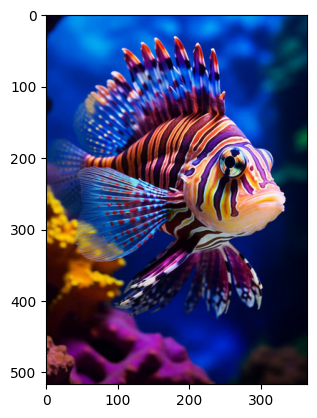

In [3]:
#Display the original image that we want to compress
image_original = load_image('fish.png')
plt.imshow(image_original);

In [4]:
image_original.shape

(517, 365, 3)

In [5]:
"""
The intensity of the i-th color (i = 0 for red, i = 1 for green, i = 2 for blue) placed in (x, y) 
is defined by the value image_original[x, y, i] for .png extension and by image_original[x, y, i]/255
for .jpg extension, where 0 <= x <= image_original.shape[0] - 1 
and 0 <= y <= image_original.shape[1] - 1
"""
print(image_original[2, 265, 0], 'red intensity for the pixel in position (2, 265)') 
print(image_original[119, 54, 1], 'green intensity for the pixel in position (119, 54)') 
print(image_original[45, 34, 2], 'blue intensity for the pixel in position (45, 34)') 

0.0 red intensity for the pixel in position (2, 265)
0.30588236 green intensity for the pixel in position (119, 54)
0.85490197 blue intensity for the pixel in position (45, 34)


In [6]:
#Transform the original data (image_original) to make it adequate for processing
X = np.reshape(image_original, (image_original.shape[0]*image_original.shape[1], 3))
X.shape

(188705, 3)

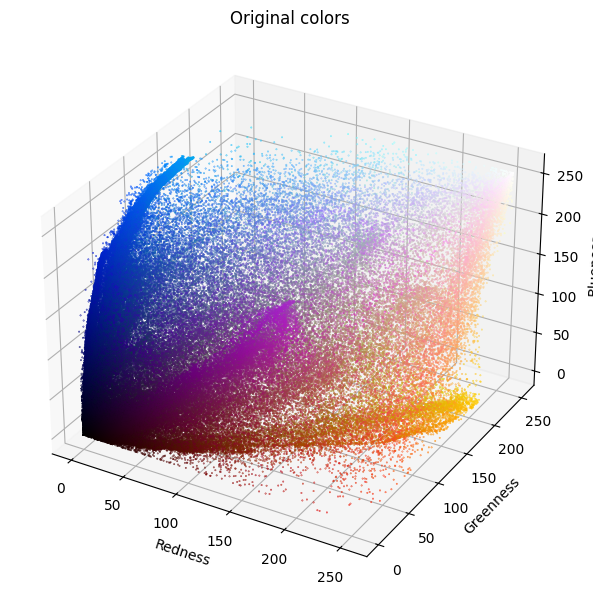

In [7]:
#Plot all the colors that are present in the image to infer a razonable number of centroids (reduced number of total colors)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(*X.T*255, zdir = 'z', depthshade = False, s = .1, c = X)
ax.set_xlabel('Redness')
ax.set_ylabel('Greenness')
ax.set_zlabel('Blueness')
ax.set_title("Original colors")
plt.show()

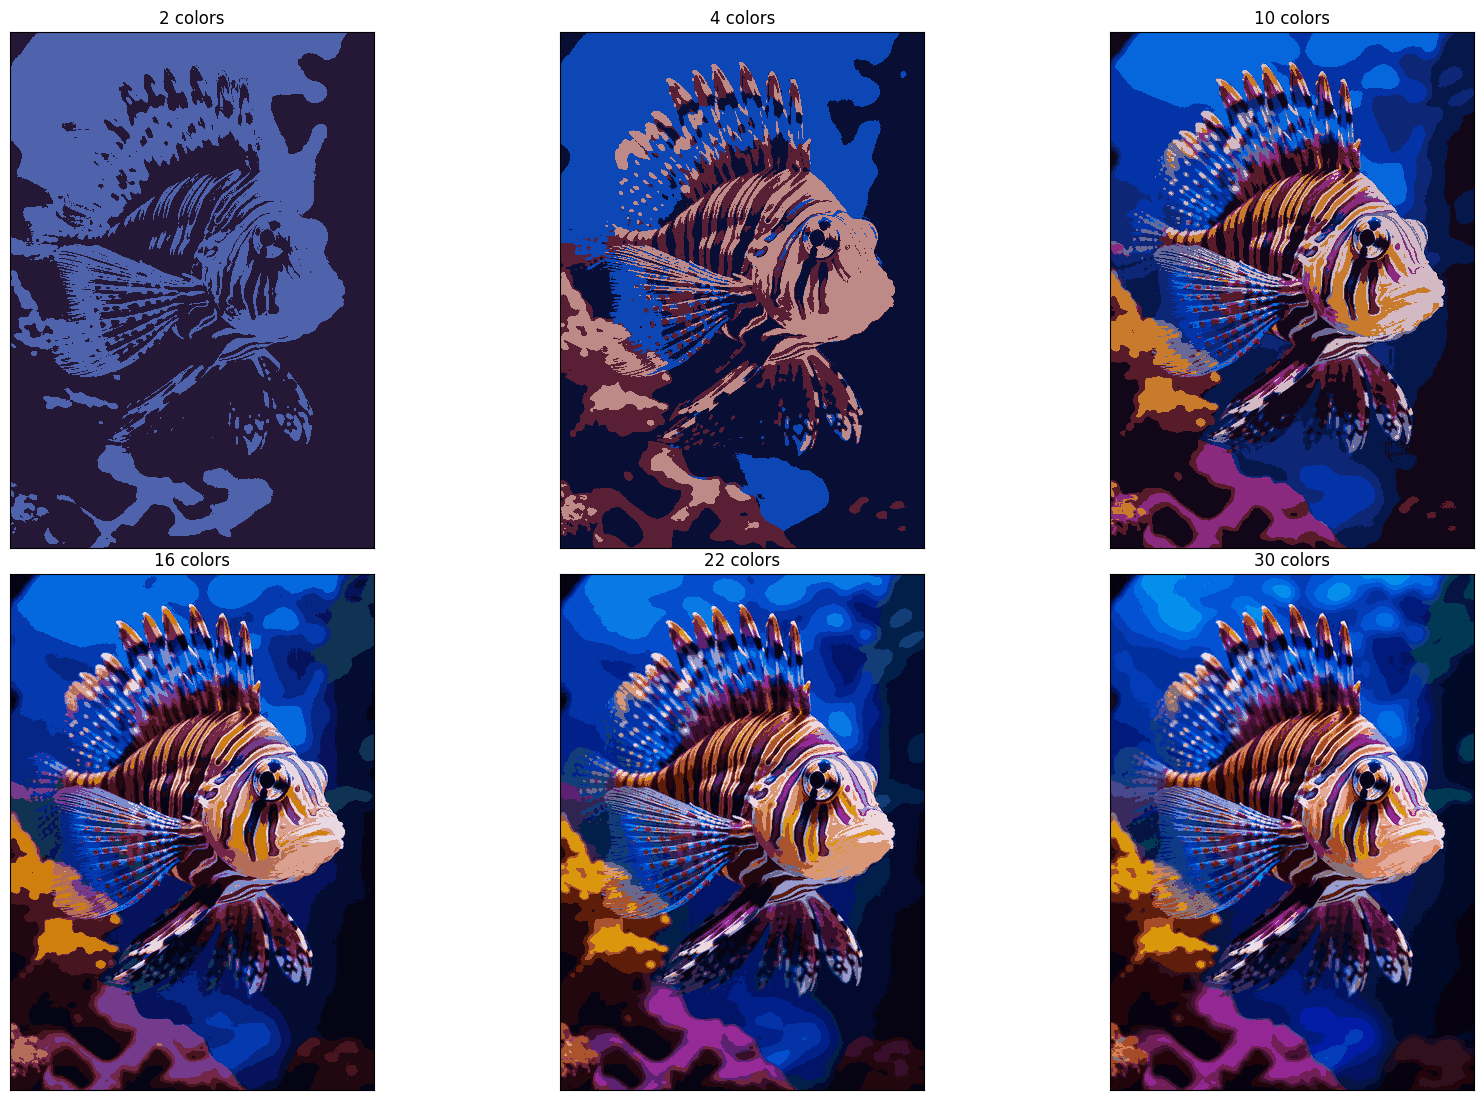

In [8]:
#We run K-means algorithm for several values of K:
number_clusters = [2, 4, 10, 16, 22, 30]
images_k = []
for K in number_clusters:
    centroids_init = kmeans_init_centroids(X, K)
    centroids_final, idx = run_kmeans(X, centroids_init, iterations = 6)
    idx_final = closest_centroid(X, centroids_final)
    X_compressed = centroids_final[idx_final, :]
    image_compressed = np.reshape(X_compressed, image_original.shape)
    images_k.append(image_compressed) #aca es el problema 


fig = plt.figure(figsize=(16,16)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.1)
for i in range(len(number_clusters)):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(images_k[i])
    ax.set_title('%d colors' %number_clusters[i])

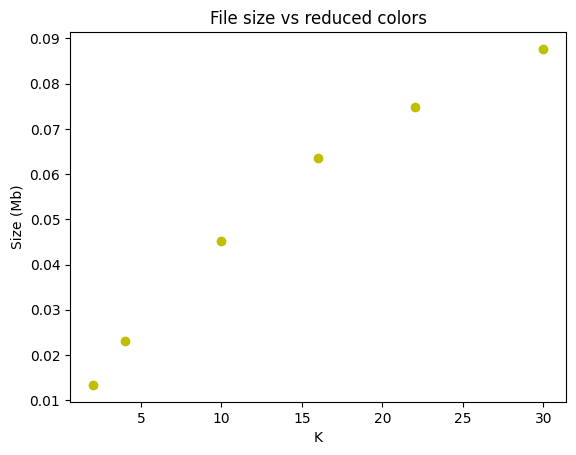

In [10]:
#We save all the reduced images, compute the size in Mb and plot size against the number of colors
list_size = []
for i in range(len(number_clusters)):
    im = Image.fromarray((images_k[i] * 255).astype(np.uint8))
    file = "fish_reduced_%d_colors.png"%number_clusters[i]
    im.save(file)
    list_size.append(os.stat(file).st_size/1024**2)

plt.scatter(number_clusters, list_size, marker = 'o', c = 'y')
plt.title('File size vs reduced colors')
plt.xlabel('K')
plt.ylabel('Size (Mb)');